# **Temporal Difference Learning**

En esta práctica aprenderemos a implementar dos de los algoritmos *Temporal Difference Learning* más utilizados, **SARSA** (on-policy) y **Q-Learning** (off-policy).

En primer lugar, instalaremos (si es necesario) e importaremos las librerías que vamos a utilizar a lo largo de la práctica.

In [25]:
!pip install gymnasium pygame
!pip install imageio

In [26]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio
from IPython.display import HTML
import random

## Descripción del entorno

Evaluaremos los métodos que implementemos en el entorno de Gymnasium `CliffWalking-v1` ([ver para una descripción completa del entorno](https://gymnasium.farama.org/environments/toy_text/cliff_walking/)).

El objetivo del agente será cruzar una cuadrícula desde un punto inicial hasta la meta sin caer por el acantilado. Si el agente se mueve hasta una casilla de acantilado, volverá al punto inicial. El agente podrá moverse en las 4 direcciones (arriba, abajo, izquierda, derecha). Cada timestep supone una recompensa de -1. Si el agente pisa el acantilado, recibe una recompensa de -100.

El episodio termina cuando el agente llega a la casilla de meta.

Crea el entorno `CliffWalking-v1` con `render_mode="rgb_array"` utilizando `gym.make()`.

In [27]:
env = gym.make('CliffWalking-v1', render_mode="rgb_array")

### Visualización

Utiliza `env.reset()` y `env.render()` para visualizar el entorno.

array([[[ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97],
        ...,
        [ 86, 170,  69],
        [ 86, 170,  69],
        [ 86, 170,  69]],

       [[ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97],
        ...,
        [ 86, 170,  69],
        [ 86, 170,  69],
        [ 86, 170,  69]],

       [[ 91, 150,  97],
        [ 91, 150,  97],
        [ 98, 166, 105],
        ...,
        [105, 182,  74],
        [105, 182,  74],
        [ 86, 170,  69]],

       ...,

       [[ 86, 170,  69],
        [ 86, 170,  69],
        [ 93, 188,  74],
        ...,
        [ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97]],

       [[ 86, 170,  69],
        [ 86, 170,  69],
        [ 93, 188,  74],
        ...,
        [ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97]],

       [[ 86, 170,  69],
        [ 86, 170,  69],
        [ 86, 170,  69],
        ...,
        [ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97]]], dtype=uint8)
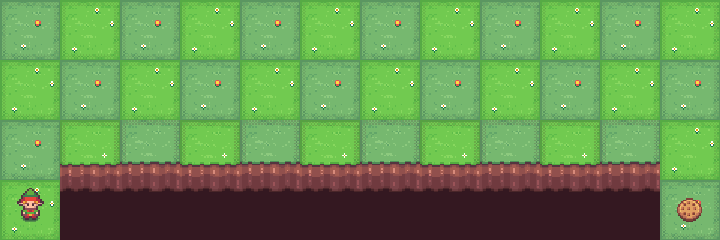

In [28]:
env.reset()
env.render()

### Observation space & Action space

Obtén información acerca del tipo de espacio de acción (`env.action_space`) y de observación (`env.observation_space`) de este entorno y el número de estados y acciones posibles.

In [29]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


## SARSA

SARSA es un método on-policy que recibe su nombre del ciclo $State - Action - Reward - State - Action$.

La regla de actualización del algoritmo SARSA es:

$$
Q(S_{t}, A_{t}) → Q(S_{t}, A_{t}) + α[R_{t+1} + γQ(S_{t+1}, A_{t+1}) - Q(S_{t}, A_{t})]
$$

Donde:
- $α$ es el learning rate o step-size parameter, que controla la velocidad de aprendizaje
- $R$ es la recompensa recibida tras tomar la acción
- $γ$ es el discount rate que determina la importancia de las recompensas futuras
- $Q(S_{t+1}, A_{t+1})$ es el valor estimado $Q$ del siguiente par estado-acción

El término $[R_{t+1} + γQ(S_{t+1}, A_{t+1}) - Q(S_{t}, A_{t})]$ es el error de diferencia temporal. Este error ayuda al agente a refinar continuamente sus estimaciones, conduciendo el proceso de aprendizaje hacia la política óptima.


### Política ɛ-greedy

Define una política ɛ-greedy (debe seleccionar una acción al azar con una probabilidad ɛ, en otro caso seleccionará la acción con Q-value mayor):

In [30]:
def epsilon_greedy(env, epsilon, Q, state):
    if np.random.rand() < epsilon:
        # Devuelve acción aleatoria
        return env.action_space.sample()
    else:
       return int(np.argmax(Q[state]))
        # Devuelve la acción greedy

### Implementación del algoritmo

Implementa el algoritmo SARSA. (Opcionalmente puedes llevar un registro de la recompensa total y longitud por episodio e imprimir por pantalla cada cierto número de episodios para observar la evolución del aprendizaje).

In [31]:
def sarsa(env, n_episodes, alpha, gamma, epsilon):
    # Inicializa la Q-table con valores a cero
    n_states = env.observation_space.n
    n_actions =env.action_space.n
    Q_table = np.zeros((n_states, n_actions))

    # Algoritmo SARSA
    # Iteramos sobre todos los episodios
    for episode in range(n_episodes):
        # Generamos un episodio y actualizamos la Q-table
        # según la regla de actualización
        state, _ = env.reset()

        done=False

        while not done:
          action=epsilon_greedy(env,epsilon,Q_table,state)
          next_state, reward, terminated, truncated, _ = env.step(action)
          # El episodio habrá terminado si así lo indican terminated o truncated
          done = terminated or truncated
          # Actualizamos la variable estado al nuevo
          next_action=epsilon_greedy(env,epsilon,Q_table,next_state)
          Q_table[state,action]+=alpha*(reward+(gamma*Q_table[next_state,next_action])-Q_table[state,action])
          state = next_state
    # Devuelve la Q-table con los valores óptimos
    return Q_table

### Entrenamiento

Definimos los hiperparámetros del algoritmo (learning rate, factor de descuento, epsilon y número de episodios de entrenamiento)

In [32]:
alpha = 0.2
gamma = 0.99
epsilon = 0.1
n_episodes = 20000

Y obtenemos la Q-table con los valores óptimos.

In [33]:
Q_table = sarsa(env, n_episodes, alpha, gamma, epsilon)

### Evaluación del comportamiento aprendido del agente

Crearemos una animación con los frames correspondientes a la ejecución de un episodio siguiendo el comportamiento marcado por los valores Q aprendidos.

Define una función que ejecute un episodio sin exploración, escogiendo siempre la acción que maximice el valor Q para el estado encontrado, y guarda los frames de cada timestep con `env.render()` para poder crear la animación a continuación.

In [34]:
def run_episode(env,Q_table):
  # Resetear el entorno para obtener el estado inicial
    state, _ = env.reset()
    trajectory =[env.render()]
    done=False
    total_reward=0
    while not done:
      action=np.argmax(Q_table[state])
      next_state, reward, terminated, truncated, _ = env.step(action)
      # El episodio habrá terminado si así lo indican terminated o truncated
      done = terminated or truncated
      # Actualizamos la variable estado al nuevo
      trajectory.append(env.render())
      total_reward+=reward
      state = next_state
    return trajectory,total_reward

Crea una animación con `animation.FuncAnimation` a partir de los frames obtenidos al ejecutar el episodio y muéstrala con `HTML`.

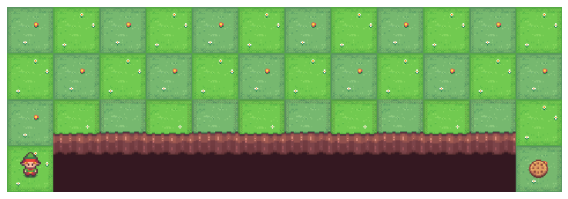

In [37]:
# Run an episode and get the frames
frames,_ = run_episode(env, Q_table)

# Create the animation
fig = plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
ax = fig.add_subplot(111)
ax.set_axis_off()
im = ax.imshow(frames[0])

def animate(i):
    im.set_array(frames[i])
    return [im]

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)

# Display the animation
HTML(anim.to_html5_video())

Cierra el entorno.

In [38]:
env.close()

## Q-Learning

Q-learning es un algoritmo off-policy, model-free, que encuentra la mejor secuencia de acciones basándose en el estado actual del agente. La actualización se basa en el máximo valor Q del siguiente estado, que es la recompensa más alta posible que el agente podría alcanzar desde el siguiente estado, independientemente de la acción que se eligió en realidad.

La regla de actualización del algoritmo Q-learning es:

$$
Q(S_{t}, A_{t}) ← Q(S_{t}, A_{t}) + α[R_{t+1} + γ max_{a}Q(S_{t+1}, a) - Q(S_{t}, A_{t})]
$$

Creamos de nuevo el entorno de `CliffWalking-v1`.

In [39]:
env = gym.make('CliffWalking-v1', render_mode="rgb_array")

### Implementación del algoritmo

Implementa una función para la política de comportamiento (que será una política ɛ-greedy).

In [43]:
def epsilon_greedy1(env, epsilon, Q, state):
    if np.random.rand() < epsilon:
        # Devuelve acción aleatoria
        return env.action_space.sample()
    else:
       return int(np.argmax(Q[state]))
        # Devuelve la acción greedy

Implementa el algoritmo Q-learning. (Opcionalmente puedes realizar un seguimiento de la recompensa total y longitud por episodio para observar la evolución del aprendizaje).

In [48]:
def q_learning(env, n_training_episodes, alpha, gamma, epsilon):
    # Inicializa la Q-table con los valores a cero
    # Inicializa la Q-table con valores a cero
    n_states = env.observation_space.n
    n_actions =env.action_space.n
    Q_table = np.zeros((n_states, n_actions))
    # Algoritmo Q-learning
    # Para todos los episodios
    for episode in range(n_training_episodes):
        # Obtén el estado inicial del entorno
        # Generamos un episodio y actualizamos la Q-table
        # según la regla de actualización
        state, _ = env.reset()

        done=False

        while not done:
          action=epsilon_greedy1(env,epsilon,Q_table,state)
          next_state, reward, terminated, truncated, _ = env.step(action)
          # El episodio habrá terminado si así lo indican terminated o truncated
          done = terminated or truncated
          # Actualizamos la variable estado al nuevo

          Q_table[state,action]+=alpha*(reward+(gamma*np.max(Q_table[next_state]))-Q_table[state,action])
          state = next_state
        # Generamos un episodio y actualizamos la Q-table
        # según la regla de actualización


    # Devuelve la Q-table con los valores óptimos
    return Q_table

### Entrenamiento

Definimos los hiperparámetros del algoritmo (learning_rate, factor de descuento, epsilon y número de episodios de entrenamiento).

In [49]:
alpha = 0.2
gamma = 0.99
epsilon = 0.1
n_training_episodes = 20000

Y obtenemos la Q-table con los valores óptimos.

In [50]:
Q_table = q_learning(env, n_training_episodes, alpha, gamma, epsilon)

### Evaluación del comportamiento aprendido del agente

Crea una animación a partir de los frames del episodio generado por la Q-table de valores óptimos obtenida con el algoritmo Q-learning.

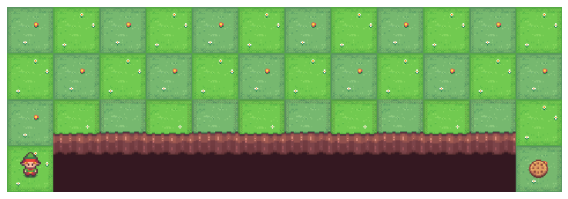

In [51]:
# Run an episode and get the frames using the Q-table from Q-learning
trajectory_q, total_reward_q = run_episode(env, Q_table)

# Create the animation
fig_q = plt.figure(figsize=(trajectory_q[0].shape[1] / 72.0, trajectory_q[0].shape[0] / 72.0), dpi = 72)
ax_q = fig_q.add_subplot(111)
ax_q.set_axis_off()
im_q = ax_q.imshow(trajectory_q[0])

def animate_q(i):
    im_q.set_array(trajectory_q[i])
    return [im_q]

anim_q = animation.FuncAnimation(fig_q, animate_q, frames=len(trajectory_q), interval=50)

# Display the animation
HTML(anim_q.to_html5_video())

Cierra el entorno.

In [52]:
env.close()